In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

/home/alexander/miniconda3/envs/2_ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## OpenAI Gym

In [59]:
env = gym.make('FrozenLake-v0')
env.reset()
for _ in range(5):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG


## Policy iteration по уравнениям Беллмана

In [3]:
nS, nA = env.env.nS, env.env.nA
final_states = np.where([ len(env.env.P[x][0]) == 1 and env.env.P[x][0][0][3] == True for x in env.env.P.keys() ])[0]

def get_random_V(env):
    V = np.random.random(nS)
    V[final_states] = 0.0
    return V

def get_random_Q(env):
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0.0
    return Q

In [4]:
def compute_V_by_policy(env, pi, gamma=1.0):
    V = get_random_V(env)
    while True:
        new_V = np.array([ \
          np.sum([ x[0] * ( x[2] + gamma * V[x[1]] ) for x in env.env.P[cur_state][pi[cur_state]] ]) \
        for cur_state in range(nS) ])
        if np.sum((V - new_V) ** 2) < 0.001:
            break
        V = new_V
    return V

def compute_policy_by_V(env, V, gamma=1.0):
    return np.argmax( np.array([[ \
          np.sum([ x[0] * ( x[2] + gamma * V[x[1]] ) for x in env.env.P[s][a] ]) \
        for a in range(nA) ] for s in range(nS)]), axis=1 )

In [5]:
def compute_V_and_pi(env, gamma=1.0):
    V = get_random_V(env)
    pi = np.random.randint(nA, size=nS)

    while True:
        V = compute_V_by_policy(env, pi, gamma)
        new_pi = compute_policy_by_V(env, V, gamma)
        if np.array_equal(pi, new_pi):
            break
        pi = new_pi
    
    return V, pi

In [6]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000

num_experiments = 200
num_steps, total_reward = [], []

V, pi = compute_V_and_pi(env)

for _ in range(num_experiments):
    env.reset()
    total_reward.append(0)
    for step in range(1000):
        observation, reward, done, info = env.step(pi[env.env.s])
        total_reward[-1] += reward
        if done:
            num_steps.append(step+1)
            break
env.close()

print("\nСредняя награда: %.6f\nСреднее число шагов: %.6f" % (np.mean(total_reward), np.mean(num_steps)))


Средняя награда: 0.745000
Среднее число шагов: 44.345000


In [10]:
def compute_V_max(env, gamma=1.0):
    V = get_random_V(env)
    while True:
        new_V = np.array([ [ \
          np.sum([ x[0] * ( x[2] + gamma * V[x[1]] ) for x in env.env.P[cur_state][cur_action] ]) \
        for cur_action in range(nA) ] for cur_state in range(nS) ])
        new_V = np.max(new_V, axis=1)
        if np.sum((V - new_V) ** 2) < 0.001:
            break
        V = new_V
    return V

def compute_Q_max(env, gamma=1.0):
    Q = get_random_Q(env)
    while True:
        new_Q = np.array([ [ \
          np.sum([ x[0] * ( x[2] + gamma * np.max(Q[x[1], :]) ) for x in env.env.P[cur_state][cur_action] ]) \
        for cur_action in range(nA) ] for cur_state in range(nS) ])
#         new_V = np.max(new_V, axis=1)
        if np.sum((Q - new_Q) ** 2) < 0.001:
            break
        Q = new_Q
    return Q

def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax( Q, axis=1 )

def conduct_experiments_max(env, gamma, use_Q=False, num_experiments=100, num_experiments_pi=200):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        if use_Q:
            Q = compute_Q_max(env, gamma=gamma)
            pi = compute_policy_by_Q(env, Q)
        else:
            V = compute_V_max(env, gamma=gamma)
            pi = compute_policy_by_V(env, V)
        result = conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi)
        num_steps.append(result[0])
        total_reward.append(result[1])
    return np.mean(num_steps), np.mean(total_reward)

In [7]:
def conduct_experiments_pi(env, pi, num_experiments=1000):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        env.reset()
        num_steps.append(0)
        total_reward.append(0)
        for _ in range(1000):
            observation, reward, done, info = env.step(pi[env.env.s])
            total_reward[-1] += reward
            num_steps[-1] += 1
            if done:
                break
    env.close()
    return np.mean(total_reward), np.mean(num_steps)

def conduct_experiments(env, gamma=1.0, num_experiments=100, num_experiments_pi=10):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        V, pi = compute_V_and_pi(env, gamma=gamma)
        cur_steps, cur_reward = conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi)
        num_steps.append(cur_steps)
        total_reward.append(cur_reward)
    return np.mean(num_steps), np.mean(total_reward)

In [8]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000
results = []
for gamma in np.linspace(0.5, 0.95, 10):
    mean_reward, mean_steps = conduct_experiments(env, gamma, num_experiments=100, num_experiments_pi=10)
    results.append([gamma, mean_reward, mean_steps])
    print("gamma=%.4f, mean reward = %.4f, mean steps = %.4f" % (gamma, mean_reward, mean_steps) )
env.close()

gamma=0.5000, mean reward = 0.6960, mean steps = 50.3490
gamma=0.5500, mean reward = 0.7220, mean steps = 40.8560
gamma=0.6000, mean reward = 0.7400, mean steps = 42.9520
gamma=0.6500, mean reward = 0.7340, mean steps = 41.1920
gamma=0.7000, mean reward = 0.7720, mean steps = 41.9910
gamma=0.7500, mean reward = 0.7660, mean steps = 41.8370
gamma=0.8000, mean reward = 0.7560, mean steps = 41.5660
gamma=0.8500, mean reward = 0.7570, mean steps = 43.5080
gamma=0.9000, mean reward = 0.7540, mean steps = 43.3760
gamma=0.9500, mean reward = 0.8390, mean steps = 55.7380


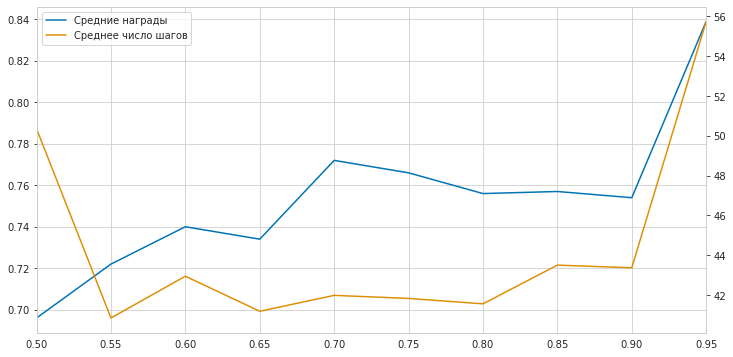

In [9]:
def plot_results(results):
    gammas, rewards, numsteps = [x[0] for x in results], [x[1] for x in results], [x[2] for x in results]
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax2 = ax.twinx()
    ax2.grid(None)

    line1 = ax.plot(gammas, rewards, label="Средние награды", color="C0")
    line2 = ax2.plot(gammas, numsteps, label="Среднее число шагов", color="C1")

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=2)
    ax.set_xlim((0.5, 0.95))
    # ax.set_ylim((0.1, 0.8))
    # ax2.set_ylim((10, 45))
    return fig, ax

fig, ax = plot_results(results)

## Value iteration по уравнениям Беллмана

In [61]:
Q.shape

(16, 4)

In [62]:
np.argmax( Q, axis=1 )

array([0, 3, 1, 3, 0, 0, 1, 0, 3, 1, 0, 0, 0, 2, 1, 0])

In [11]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000

V = compute_V_max(env)
pi = compute_policy_by_V(env, V, gamma=0.99)
print(pi)

env.close()

[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


In [12]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000

Q = compute_Q_max(env)
pi = compute_policy_by_Q(env, Q)
print(pi)

env.close()

[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


In [13]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000

results_max = []
for gamma in np.linspace(0.5, 0.95, 10):
    mean_reward, mean_steps = conduct_experiments_max(env, gamma, use_Q=True, num_experiments=20, num_experiments_pi=100)
    results_max.append([gamma, mean_reward, mean_steps])
    print("gamma=%.4f, mean reward = %.4f, mean steps = %.4f" % (gamma, mean_reward, mean_steps) )
env.close()

gamma=0.5000, mean reward = 0.5155, mean steps = 231.8400
gamma=0.5500, mean reward = 0.5480, mean steps = 33.9895
gamma=0.6000, mean reward = 0.6270, mean steps = 36.3860
gamma=0.6500, mean reward = 0.7555, mean steps = 42.2055
gamma=0.7000, mean reward = 0.7385, mean steps = 41.6265
gamma=0.7500, mean reward = 0.7645, mean steps = 43.4440
gamma=0.8000, mean reward = 0.7810, mean steps = 43.8085
gamma=0.8500, mean reward = 0.7850, mean steps = 44.3325
gamma=0.9000, mean reward = 0.7985, mean steps = 43.5270
gamma=0.9500, mean reward = 0.8220, mean steps = 48.4395


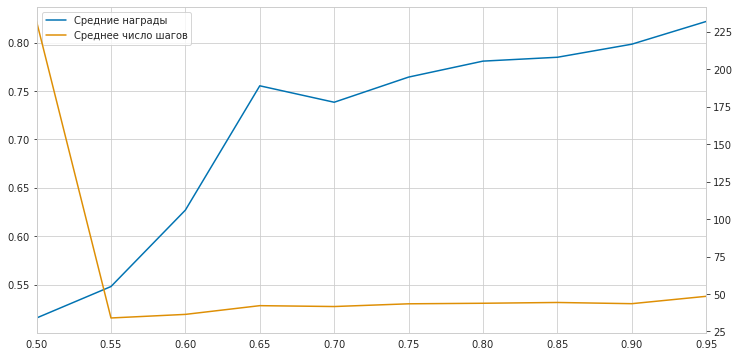

In [14]:
fig, ax = plot_results(results_max)

## First-visit Monte Carlo по состояниям

In [15]:
def run_episode(env, pi):
    env.reset()
    states, rewards = [env.env.s], [0]
    for _ in range(1000):
        observation, reward, done, info = env.step(pi[env.env.s])
        states.append(env.env.s)
        rewards.append(reward)
        if done:
            break
    return states, rewards

def update_returns(R, states, rewards, R_all=None):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t
    g = 0
    if state_first_visit[states[-1]] == len(states)-1:
        R[states[-1]].append(g)
        if R_all is not None:
            R_all[states[t]].append(g)
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[states[t]] == t:
            R[states[t]].append(g)
            if R_all is not None:
                R_all[states[t]].append(g)
    for state in range(nS):
        if state_first_visit[state] == -1:
            R_all[state].append(np.nan)
    return R, R_all

In [16]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000
total_episodes = 1000
gamma = 0.9

Q = compute_Q_max(env, gamma)
pi = compute_policy_by_Q(env, Q)

V = get_random_V(env)
R, R_all = [ [] for _ in range(nS) ], [ [] for _ in range(nS) ]

for _ in range(total_episodes):
    states, rewards = run_episode(env, pi)
    R, R_all = update_returns(R, states, rewards, R_all=R_all)

for state in range(nS):
    if len(R[state]) > 0:
        V[state] = np.mean(R[state])

env.close()

(1.0, 1000.0)

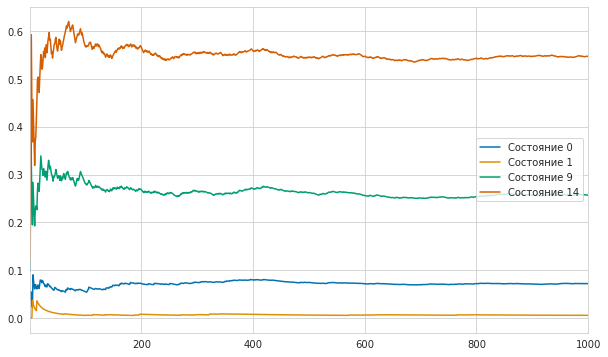

In [17]:
mean_returns = [ np.true_divide( np.nancumsum(R_all[s]), np.arange(1, len(R_all[s])+1) ) for s in range(nS) ]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i,s in enumerate([0, 1, 9, 14]):
    ax.plot(np.arange(1, len(R_all[s])+1), mean_returns[s], label="Состояние %d" % s, color="C%d" % i)

ax.legend(loc="center right")
ax.set_xlim((1, 1000))
# ax.set_ylim((0.1, 0.8))
# ax2.set_ylim((10, 45))

In [18]:
def run_episode_actions(env, pi, eps=0.0):
    env.reset()
    next_action = pi[env.env.s] if np.random.rand() > eps else np.random.randint(nA)
    states, actions, rewards = [env.env.s], [next_action], [0]
    for _ in range(1000):
        observation, reward, done, info = env.step(next_action)
        states.append(env.env.s)
        next_action = pi[env.env.s] if np.random.rand() > eps else np.random.randint(nA)
        actions.append(next_action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards

def update_returns_actions(R, states, actions, rewards, gamma=1.0, R_all=None):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t
    g = 0
    if R_all is not None:
        _ = [R_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]
    if state_first_visit[states[-1]] == len(states)-1:
        R[states[-1]][actions[-1]].append(g)
        if R_all is not None:
            R_all[states[t]][actions[t]][-1] = g
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[states[t]] == t:
            R[states[t]][actions[t]].append(g)
            if R_all is not None:
                R_all[states[t]][actions[t]][-1] = g
    return R, R_all

In [19]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000
total_episodes = 20000
gamma = 0.9

Q_max = compute_Q_max(env, gamma)
pi = compute_policy_by_Q(env, Q_max)

R, R_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ], [ [ [] for _ in range(nA) ] for _ in range(nS) ]

for _ in range(total_episodes):
    states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
    R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)

Q = [ [np.mean(R[s][a]) if len(R[s][a]) > 0 else -1 for a in range(nA)] for s in range(nS)]

env.close()

In [20]:
np.set_printoptions(precision=6, suppress=True)
print("Оптимальная функция Q:\n%s\n\nПолученная нами функция Q:\n%s" % (Q_max, np.array(Q)))

Оптимальная функция Q:
[[0.129901 0.125447 0.125447 0.120317]
 [0.078727 0.078194 0.07374  0.115331]
 [0.115198 0.112595 0.112062 0.107742]
 [0.070605 0.070605 0.068002 0.104606]
 [0.147702 0.106111 0.100981 0.088311]
 [0.       0.       0.       0.      ]
 [0.134444 0.09784  0.134444 0.036604]
 [0.       0.       0.       0.      ]
 [0.106111 0.144566 0.131895 0.191286]
 [0.181325 0.279165 0.219774 0.157231]
 [0.322521 0.281064 0.237346 0.126632]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.207109 0.317823 0.402998 0.281064]
 [0.415663 0.651156 0.627062 0.553107]
 [0.       0.       0.       0.      ]]

Полученная нами функция Q:
[[0.050591 0.046276 0.056644 0.046487]
 [0.030606 0.027562 0.025067 0.044667]
 [0.057068 0.053667 0.042646 0.039619]
 [0.025016 0.       0.13397  0.034963]
 [0.070242 0.042397 0.042597 0.027206]
 [0.       0.       0.       0.      ]
 [0.094751 0.065226 0.102577 0.024285]
 [0.       0.       0.       0.      ]
 [0.051475 0

In [21]:
def get_mean_returns(R_all):
    mean_returns = [[[] for _ in range(nA)] for _ in range(nS)]
    for s in range(nS):
        for a in range(nA):
            cur_denominator, cur_value = 0., 0.
            for r in R_all[s][a]:
                if not np.isnan(r):
                    cur_denominator += 1.
                    cur_value += r
                mean_returns[s][a].append(cur_value / cur_denominator if cur_denominator > 0 else 0)
    return mean_returns
                
mean_returns = get_mean_returns(R_all)

(1.0, 2000.0)

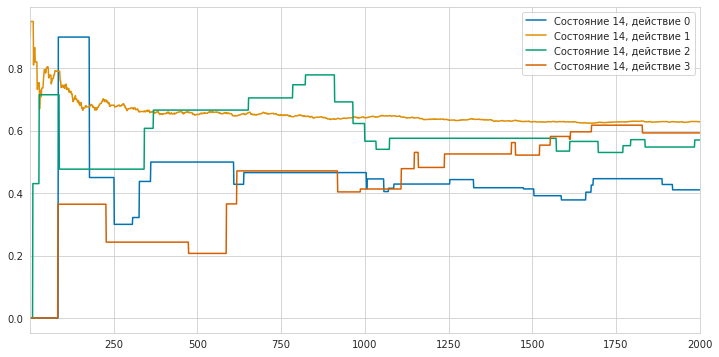

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ss = 14
for i,s_a in enumerate([(ss,0), (ss,1), (ss,2), (ss,3)]):
# for i,s_a in enumerate([(0,0), (4,0), (14,1), (13,2)]):
    s,a = s_a
    ax.plot(np.arange(1, len(R_all[s][a])+1), mean_returns[s][a], label="Состояние %d, действие %d" % (s, a), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlim((1, 2000))
# ax.set_ylim((0.1, 0.8))
# ax2.set_ylim((10, 45))

## Monte-Carlo control с on-policy исследованием

In [23]:
def get_Q_by_R(R, Q_default=None):
    Q = Q_default if Q_default is not None else np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            if len(R[s][a]) > 0:
                Q[s][a] = np.mean(R[s][a])
    return Q

In [24]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000
init_episodes, total_episodes = 100, 10000
gamma = 0.9

Q_max = compute_Q_max(env, gamma)
pi_max = compute_policy_by_Q(env, Q_max)

R, R_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ], [ [ [] for _ in range(nA) ] for _ in range(nS) ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

for _ in range(init_episodes):
    states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
    R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)

for _ in range(total_episodes):
    states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
    R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)
    Q = get_Q_by_R(R, Q_default=Q)
    pi = compute_policy_by_Q(env, Q)

env.close()

In [25]:
print("Лучшая стратегия:\t%s" % pi_max)
print("Текущая стратегия:\t%s" % pi)

Лучшая стратегия:	[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]
Текущая стратегия:	[0 1 2 3 0 0 0 0 3 1 0 0 0 2 1 0]


In [26]:
mean_returns = get_mean_returns(R_all)

Text(0, 0.5, 'Текущая оценка')

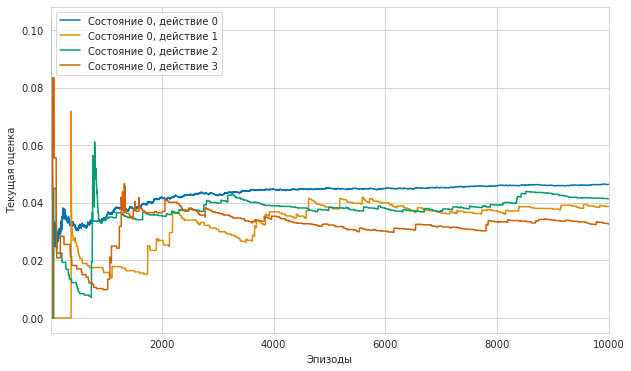

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ss = 0
for i,s_a in enumerate([(ss,0), (ss,1), (ss,2), (ss,3)]):
    s,a = s_a
    ax.plot(np.arange(1, len(R_all[s][a])+1), mean_returns[s][a], label="Состояние %d, действие %d" % (s, a), color="C%d" % i)

ax.legend(loc="upper left")
ax.set_xlim((1, 10000))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка")

## Monte-Carlo control с off-policy исследованием

In [28]:
def update_lists(s, a, g, w, Q, C, Q_all):
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]
    if Q_all is not None:
        Q_all[s][a][-1] = g


def update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=0.1, gamma=1.0, Q_all=None):
    g, w, prob_best_action = 0., 1., 1 - (nA-1) * epsilon / nA
    if Q_all is not None:
        _ = [Q_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]

    # Обновляем функции для последнего хода
    update_lists(states[-1], actions[-1], g, w, Q, C, Q_all)
    
    for t in range(len(states)-2, -1, -1):
        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if actions[t+1] != pi[states[t+1]]:
            break
            
        # Обновляем веса и return
        w = w / ( prob_best_action )
        g =  g * gamma + rewards[t+1]
        
        # Обновляем функции
        update_lists(states[t], actions[t], g, w, Q, C, Q_all)
    return Q, C, Q_all

In [29]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000
total_episodes = 250000
gamma = 0.9

Q_max = compute_Q_max(env, gamma)
pi_max = compute_policy_by_Q(env, Q_max)

Q_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)
C = np.zeros((nS, nA), dtype=float)

for _ in range(total_episodes):
    states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
    Q, C, Q_all = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, gamma=gamma, Q_all=Q_all)
    pi = compute_policy_by_Q(env, Q)

env.close()

In [30]:
np.set_printoptions(precision=6, suppress=True)
print("Оптимальная функция Q:\n%s\n\nПолученная нами функция Q:\n%s" % (Q_max, np.array(Q)))

Оптимальная функция Q:
[[0.122276 0.11837  0.11837  0.113037]
 [0.074056 0.074145 0.070239 0.10922 ]
 [0.110887 0.10843  0.108519 0.102945]
 [0.06787  0.06787  0.065413 0.100577]
 [0.140689 0.101708 0.096375 0.083295]
 [0.       0.       0.       0.      ]
 [0.132048 0.096884 0.132048 0.035164]
 [0.       0.       0.       0.      ]
 [0.101708 0.141178 0.128098 0.185492]
 [0.178271 0.275155 0.217761 0.154278]
 [0.319748 0.279099 0.235964 0.124432]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.204661 0.316193 0.399977 0.279099]
 [0.413076 0.649526 0.625532 0.551094]
 [0.       0.       0.       0.      ]]

Полученная нами функция Q:
[[0.067543 0.052707 0.057153 0.060494]
 [0.029492 0.039061 0.040627 0.054811]
 [0.06999  0.058399 0.065584 0.053536]
 [0.033598 0.028218 0.031427 0.051026]
 [0.089284 0.070758 0.05928  0.043872]
 [0.       0.       0.       0.      ]
 [0.098794 0.093159 0.106358 0.020888]
 [0.       0.       0.       0.      ]
 [0.061437 0

In [31]:
print("Лучшая стратегия:\n%s" % np.reshape(pi_max, (4, 4)))
print("Текущая стратегия:\n%s" % np.reshape(pi, (4, 4)))

Лучшая стратегия:
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
Текущая стратегия:
[[0 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


In [32]:
mean_returns = get_mean_returns(Q_all)

Text(0, 0.5, 'Текущая оценка')

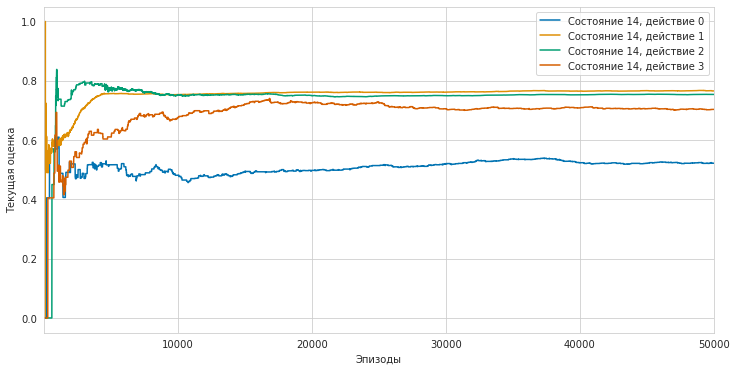

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ss = 14
for i,s_a in enumerate([(ss,0), (ss,1), (ss,2), (ss,3)]):
    s,a = s_a
    ax.plot(np.arange(1, len(Q_all[s][a])+1), mean_returns[s][a], label="Состояние %d, действие %d" % (s, a), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlim((1, 50000))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка")

## TD-обучение: on-policy (Sarsa)

In [34]:
def Sarsa_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    s, a = env.env.s, pi[env.env.s] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime, a_prime = env.env.s, pi[env.env.s] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * Q[s_prime][a_prime] - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break

In [35]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000
total_episodes = 20000
gamma = 0.9

Q_max = compute_Q_max(env, gamma)
pi_max = compute_policy_by_Q(env, Q_max)

Q_hist_Sarsa = [ ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

for n in range(1, total_episodes+1):
    Sarsa_learning_episode(env, pi, Q, alpha=0.1, epsilon= 1. / (np.log(n)+1) , gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    Q_hist_Sarsa.append(np.copy(Q))

env.close()

In [36]:
print("Лучшая стратегия:\n%s" % np.reshape(pi_max, (4, 4)))
print("Текущая стратегия:\n%s" % np.reshape(pi, (4, 4)))

Лучшая стратегия:
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
Текущая стратегия:
[[0 3 2 3]
 [1 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


In [37]:
np.set_printoptions(precision=6, suppress=True)
print("Оптимальная функция Q:\n%s\n\nПолученная нами функция Q:\n%s" % (Q_max, np.array(Q)))

Оптимальная функция Q:
[[0.128428 0.124512 0.124512 0.119344]
 [0.078258 0.077968 0.074053 0.115139]
 [0.115652 0.113689 0.113399 0.108971]
 [0.0718   0.0718   0.069837 0.106719]
 [0.146355 0.105268 0.1001   0.087341]
 [0.       0.       0.       0.      ]
 [0.13466  0.097779 0.13466  0.036881]
 [0.       0.       0.       0.      ]
 [0.105268 0.143964 0.131205 0.190219]
 [0.180735 0.278514 0.2195   0.156793]
 [0.322309 0.28071  0.237358 0.12655 ]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.206672 0.317481 0.402431 0.28071 ]
 [0.41526  0.650814 0.626872 0.552834]
 [0.       0.       0.       0.      ]]

Полученная нами функция Q:
[[0.037037 0.035702 0.035948 0.03593 ]
 [0.025618 0.031452 0.027316 0.032565]
 [0.039832 0.038585 0.040774 0.034457]
 [0.018607 0.017603 0.021132 0.02903 ]
 [0.050609 0.058437 0.030174 0.026781]
 [0.       0.       0.       0.      ]
 [0.046693 0.062872 0.04469  0.021668]
 [0.       0.       0.       0.      ]
 [0.066113 0

(0.0, 0.4)

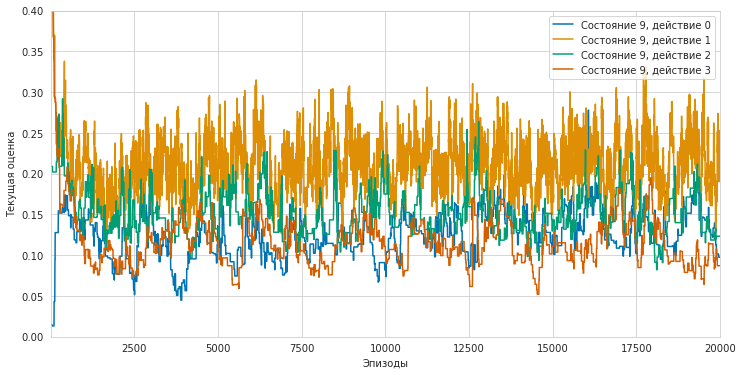

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ss = 9
for i,s_a in enumerate([(ss,0), (ss,1), (ss,2), (ss,3)]):
    s,a = s_a
    ax.plot(np.arange(1, total_episodes+1), [q[s][a] for q in Q_hist_Sarsa], label="Состояние %d, действие %d" % (s, a), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка")
ax.set_ylim((0, 0.4))

In [39]:
# Протестируем, как хорошо работают стратегии и как быстро учатся
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000

num_experiments, num_experiments_pi = 10, 50

total_episodes = 1000
gamma = 0.9

results_sarsa = []

Q_arr = [ get_random_Q(env) for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]

for n in range(1, total_episodes+1):
    _ = [ Sarsa_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= 1. / (np.log(n)+1) , gamma=gamma) for i in range(num_experiments) ]
    pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]
    result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
    results_sarsa.append([ [x[0], x[1]] for x in result ])

env.close()

Text(0.5, 0, 'Эпизоды')

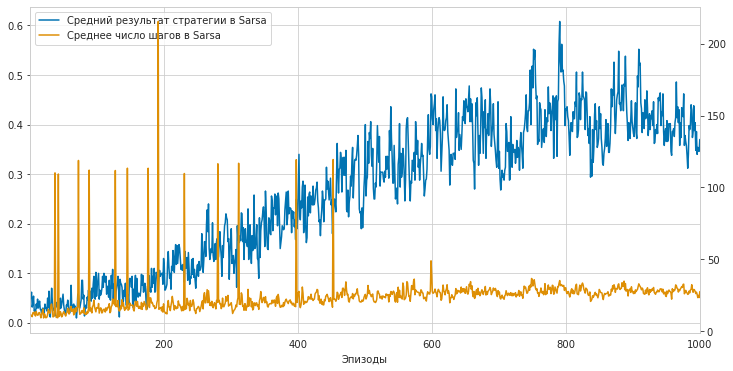

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns = np.mean( np.array([ [x[0] for x in res] for res in results_sarsa]), axis=1)
avg_steps = np.mean( np.array([ [x[1] for x in res] for res in results_sarsa]), axis=1)

line1 = ax.plot(np.arange(1, total_episodes+1), avg_returns, label="Средний результат стратегии в Sarsa", color="C0")
line2 = ax2.plot(np.arange(1, total_episodes+1), avg_steps, label="Среднее число шагов в Sarsa", color="C1")

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=0)
# ax.set_xlim((0.5, 1.0))
# ax.legend(loc="upper right")
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")

## TD-обучение: off-policy (Q-обучение)

In [41]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    s, a = env.env.s, pi[env.env.s] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime, a_prime = env.env.s, pi[env.env.s] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break

In [42]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000
total_episodes = 15000
gamma = 0.9

Q_max = compute_Q_max(env, gamma)
pi_max = compute_policy_by_Q(env, Q_max)

Q_hist_Qlearn = [ ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.1, epsilon= 0.1, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    Q_hist_Qlearn.append(np.copy(Q))

env.close()

In [43]:
print("Лучшая стратегия:\n%s" % np.reshape(pi_max, (4, 4)))
print("Текущая стратегия:\n%s" % np.reshape(pi, (4, 4)))

Лучшая стратегия:
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
Текущая стратегия:
[[0 3 1 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


In [44]:
np.set_printoptions(precision=6, suppress=True)
print("Оптимальная функция Q:\n%s\n\nПолученная нами функция Q:\n%s" % (Q_max, np.array(Q)))

Оптимальная функция Q:
[[0.123291 0.119015 0.119015 0.113674]
 [0.074357 0.074302 0.070027 0.109343]
 [0.110614 0.107712 0.107657 0.10211 ]
 [0.067069 0.067069 0.064167 0.099153]
 [0.141698 0.102381 0.09704  0.083974]
 [0.       0.       0.       0.      ]
 [0.131993 0.097008 0.131993 0.034986]
 [0.       0.       0.       0.      ]
 [0.102381 0.141763 0.128698 0.186421]
 [0.178858 0.275865 0.218142 0.154731]
 [0.320105 0.279517 0.236065 0.124628]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.205175 0.316612 0.400652 0.279517]
 [0.413619 0.649945 0.625818 0.551475]
 [0.       0.       0.       0.      ]]

Полученная нами функция Q:
[[0.084923 0.062041 0.058812 0.060552]
 [0.045331 0.039439 0.036242 0.057785]
 [0.064802 0.070513 0.060695 0.058663]
 [0.03608  0.045118 0.039147 0.052963]
 [0.117553 0.064878 0.061615 0.061634]
 [0.       0.       0.       0.      ]
 [0.078571 0.140323 0.060975 0.022322]
 [0.       0.       0.       0.      ]
 [0.0585   0

Text(0, 0.5, 'Текущая оценка')

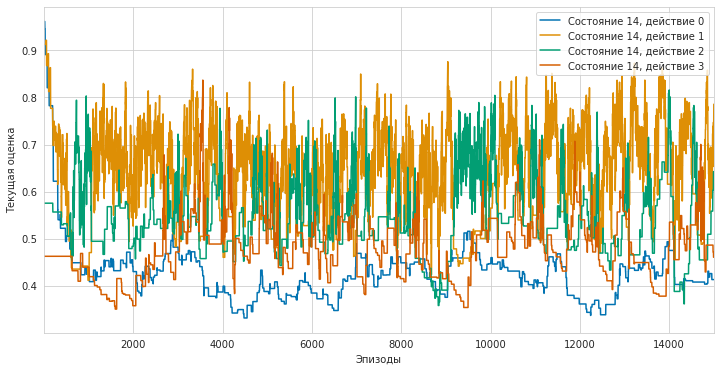

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ss = 14
for i,s_a in enumerate([(ss,0), (ss,1), (ss,2), (ss,3)]):
    s,a = s_a
    ax.plot(np.arange(1, total_episodes+1), [q[s][a] for q in Q_hist_Qlearn], label="Состояние %d, действие %d" % (s, a), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка")
# ax.set_ylim((0, 0.2))

In [46]:
# Протестируем, как хорошо работают стратегии и как быстро учатся
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 10000

num_experiments, num_experiments_pi = 10, 50

total_episodes = 1000
gamma = 0.9

results_Qlearn = []

Q_arr = [ get_random_Q(env) for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]

for n in range(1, total_episodes+1):
    _ = [ Q_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments) ]
    pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]
    result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
    results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

Text(0.5, 0, 'Эпизоды')

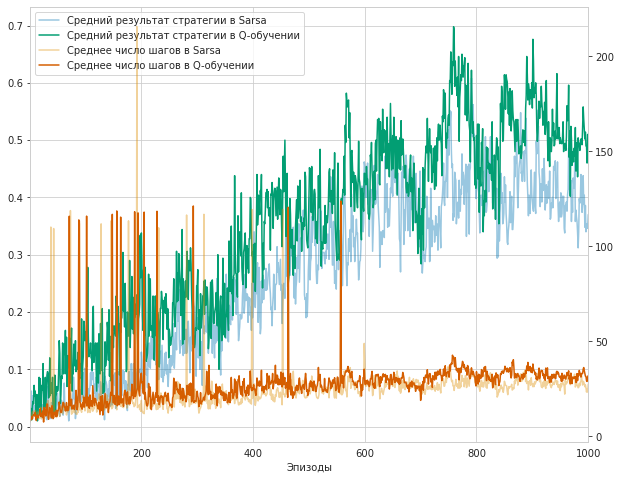

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns_Q = np.mean( np.array([ [x[0] for x in res] for res in results_Qlearn]), axis=1)
avg_steps_Q = np.mean( np.array([ [x[1] for x in res] for res in results_Qlearn]), axis=1)

line1 = ax.plot(np.arange(1, total_episodes+1), avg_returns, label="Средний результат стратегии в Sarsa", color="C0", alpha=0.4)
line2 = ax2.plot(np.arange(1, total_episodes+1), avg_steps, label="Среднее число шагов в Sarsa", color="C1", alpha=0.4)
line3 = ax.plot(np.arange(1, total_episodes+1), avg_returns_Q, label="Средний результат стратегии в Q-обучении", color="C2")
line4 = ax2.plot(np.arange(1, total_episodes+1), avg_steps_Q, label="Среднее число шагов в Q-обучении", color="C3")

lines = line1 + line3 + line2 + line4
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="upper left")
# ax.set_xlim((0.5, 1.0))
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")